# Selección de cripto activos para una cartera de inversión

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Práctico 2 -  Análisis y Curación

## Introducción


A lo largo de este práctico continuaremos con la exploración del dataset iniciada en el práctio anterior, donde notamos algunas características propias de las series temporales. 
Además, vimos que no se trata de series estacionarias y en nuestro caso no apreciamos patrones de estacionalidad para la serie de tiempo de los precios.

En la siguiente notebook, se presentan las actividades relacionadas a Análisis y Curación. Buscamos identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad. Para esto, los invito a chequear la siguiente [lista](https://dimewiki.worldbank.org/Checklist:_Data_Cleaning), donde se muestran una serie de puntos a tener en cuenta a la hora de tratar nuestros datos.

# 📖 ¡Actividades! 


Recuerden que la ciencia de datos es un proceso no lineal y continuo, es decir, si los datos requieren de mayor procesamiento para satisfacer las necesidades de algoritmos de machine learning, vamos a volver a la etapa inicial para, por ejemplo, crear nuevas features, tomar decisiones diferentes sobre valores faltantes o valores atípicos (outliers), descartar features, entre otras. ¡Manos a la obra!

Recomendación: Traten de crear funciones de manera de automatizar la mayor cantidad de pasos posibles. 

## Parte I 

- En el práctico anterior trabajamos con un conjunto de datos preprocesados, los invito a inspeccionar el siguiente conjunto de datos (link). Como pueden ver, el sistema que define las fechas no es el mismo que trabajamos durante el práctico anterior, en este caso las fechas se encuetran en tiempo Unix. Investiguen este sistema y convierta las fechas a tipo datetime. 
Para mayor información pueden ver:
    
    - [Convertir Epoch a Datetime en Python](https://www.delftstack.com/es/howto/python/python-convert-epoch-to-datetime/)


- Indaguen sobre la existencia de valores faltantes. Diferencien entre datos perdidos e inexistentes. Seleccionen un activo y visualicen utilizando la librería Missingno ¿Si uno de los precios falta, también faltan los datos en las demás columnas? ¿Cuál creen que sería la mejor forma de tratarlos? ¿Por qué? Analicen formas de imputarlos, por ejemplo, 

    - reemplazar el faltante con el valor de la media/mediana,
    - utilizar regresión. 
    - métodos backward/forward fill. 
    - Splines, etc. 
    
Para mayor información puede ver el siguiente link [Imputación](https://rpubs.com/wilsonsr/804544)

**Para discutir:** ¿Cuáles podrían ser las razones de la falta de datos, si es que esto ocurre?


- ¿Hay índices repetidos? Resuelvan. 


- Para aprovechar en mayor medida los datos disponibles, analicen dividir los datos en dos posibles conjuntos de acuerdo a la disponibilidad de información según fechas.


- ¿Podría mejorarse la forma en la que está presentada la información? Recuerden que serán necesarios todos los precios de los activos para el cálculo de features. 


- Seleccionen un activo (y alguna de las columnas referidos a precios) y confeccionen un diagrama de dispersión entre el mismo y su valor retardado un período. Repita el mismo procedimiento con sus valores retardado 2, 3 y 4 períodos. 


- Grafiquen e interpreten las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF), para el precio del activo elegido en el punto anterior. El siguiente [link](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) puede ser útil para introducirlos en el tema.


## Parte II 

En esta instancia trabajaremos con algunos features extras que iremos generando a partir de los precios disponibles. Para ello los invito a investigar [talib](http://mrjbq7.github.io/ta-lib/doc_index.html), una de las librerías de python para análisis técnico.

- Agreguen la serie de tasas de rendimientos de cada activo. 


- Calculen las medias móviles de los precios tomando n periodos hacia atrás (n a elección).  


- ¿Conocen algunos indicadores técnicos? Entre los más conocidos podemos mencionar: [RSI](https://admiralmarkets.com/es/education/articles/forex-indicators/como-sacar-beneficio-del-indicador-de-trading-rsi), [MADC](https://admiralmarkets.com/es/education/articles/forex-indicators/macd), [ADX](https://economipedia.com/definiciones/indicador-adx-average-directional-index.html), etc... Pueden construirlos o calcularlos a partir de la librería.


- Si por ejemplo, una característica tiene una varianza de un orden de magnitud mayor que la de las otras características, podría dominar la función objetivo y hacer que el estimador no pueda aprender de otras características correctamente como se esperaba. Para lograr esto se debe llevar a cabo un escalado o normalizado de datos. ¿Cuál es la diferencia?

## Opcional

- Para alguno/s de los activos, detecten las correlaciones entre los features generados utilizando la función Heatmap().




**¡Recuerde!** 

Nunca Modificar los Datos Crudos u Originales Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

# Fecha de entrega

- __Versión preliminar: 17/6__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

In [1]:
import pandas as pd
import numpy as np

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pylab import rcParams
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import os
import time
import missingno as msno

import talib as ta

import warnings
warnings.filterwarnings("ignore") 

Importamos la funcion "create_dataframe" que creamos en el primer práctico para poder leer todos los archivos e unirlos en un solo dataframe

In [2]:
def create_dataFrame(path):
    df = pd.DataFrame()
    files_list = os.listdir(path)
    for file in files_list:
        file_path = path + '/' + file
        if os.path.isfile(file_path):
            if df.empty:
                df = active_name(file_path, file)
            else:
                df = pd.concat([df, active_name(file_path, file)], axis = 0)
    return df     

def active_name(file, name):
    try:
        df = pd.read_csv(file,
                      index_col = 0,
                         #parse_dates = True, 
                         #dayfirst = True
                        )
        df.loc[:, 'active'] = name[:-4]
        return df
    except:
        print('Error en %s'% file)

# Parte I

En este caso leemos los archivos de la carpeta raw_data, para simular que recibimos los archivos directamente desde la fuente, y asi poder transformar el índice que se encuentra en formato Unix en datetime.

In [3]:
df_all = create_dataFrame('../raw_data/')
df_all.shape, df_all.head(10)

((116390, 6),
                 open    high     low   close     volume   active
 unix                                                            
 1.546312e+12  5.9317  5.9546  5.8500  5.9503  251674.71  BNBUSDT
 1.546326e+12  5.9439  5.9707  5.8808  5.9439  242875.60  BNBUSDT
 1.546340e+12  5.9440  5.9793  5.8887  5.8948  172789.33  BNBUSDT
 1.546355e+12  5.8942  5.8948  5.7735  5.8109  153940.65  BNBUSDT
 1.546369e+12  5.8011  5.9451  5.8010  5.9148  202066.15  BNBUSDT
 1.546384e+12  5.9148  6.0000  5.9006  5.9749  217243.81  BNBUSDT
 1.546398e+12  5.9754  5.9952  5.8528  5.8576  176959.11  BNBUSDT
 1.546412e+12  5.8548  5.9350  5.8371  5.9004  458312.05  BNBUSDT
 1.546427e+12  5.9005  5.9500  5.8757  5.9104  418948.13  BNBUSDT
 1.546441e+12  5.9076  6.0000  5.8910  5.9475  349169.51  BNBUSDT)

set(df_all.active)Verificamos la lista de activos que cargamos en el dataframe unico.

In [4]:
set(df_all.active)

{'AAVEUSDT',
 'ADAUSDT',
 'AXSUSDT',
 'BCHUSDT',
 'BNBUSDT',
 'BTCUSDT',
 'COMPUSDT',
 'DASHUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'EOSUSDT',
 'ETCUSDT',
 'ETHUSDT',
 'LINKUSDT',
 'LTCUSDT',
 'LUNAUSDT',
 'NEOUSDT',
 'XMRUSDT',
 'XRPUSDT'}

Para transformar el índice en formato datetime, utilizaremos la función to_datetime que pertenece a Pandas, y permite ingresar la fecha en formato de milisegundos de Unix y poder transformarlo a un lenguaje más legible.

In [5]:
df_all.index = pd.to_datetime(df_all.index.map(int), unit = 'ms', origin = 'unix')
df_all

,open,high,low,close,volume,active
unix,,,,,,
2019-01-01 03:00:00,5.9317,5.9546,5.8500,5.9503,251674.710,BNBUSDT
2019-01-01 07:00:00,5.9439,5.9707,5.8808,5.9439,242875.600,BNBUSDT
2019-01-01 11:00:00,5.9440,5.9793,5.8887,5.8948,172789.330,BNBUSDT
2019-01-01 15:00:00,5.8942,5.8948,5.7735,5.8109,153940.650,BNBUSDT
2019-01-01 19:00:00,5.8011,5.9451,5.8010,5.9148,202066.150,BNBUSDT
...,...,...,...,...,...,...
2022-05-04 23:00:00,114.8000,116.6000,114.6000,116.2000,4948.635,COMPUSDT
2022-05-05 03:00:00,116.1000,117.2000,113.4000,114.1000,4401.759,COMPUSDT
2022-05-05 07:00:00,113.9000,115.1000,112.5000,114.6000,4563.413,COMPUSDT


Vamos a agregar al dataframe las columnas de dia, mes, año, dia de la semana, profit y volumen real, para facilitar su análisis posteriormente.

In [6]:
df_all['day'] = df_all.index.day
df_all['month'] = df_all.index.month
df_all['year'] = df_all.index.year
df_all['weekday'] = df_all.index.day_name()
df_all['profit'] = 100*(df_all['close'] - df_all['open']) / df_all['open']
df_all.head(10)

,open,high,low,close,volume,active,day,month,year,weekday,profit
unix,,,,,,,,,,,
2019-01-01 03:00:00,5.9317,5.9546,5.8500,5.9503,251674.71,BNBUSDT,1,1,2019,Tuesday,0.313569
2019-01-01 07:00:00,5.9439,5.9707,5.8808,5.9439,242875.60,BNBUSDT,1,1,2019,Tuesday,0.000000
2019-01-01 11:00:00,5.9440,5.9793,5.8887,5.8948,172789.33,BNBUSDT,1,1,2019,Tuesday,-0.827725
2019-01-01 15:00:00,5.8942,5.8948,5.7735,5.8109,153940.65,BNBUSDT,1,1,2019,Tuesday,-1.413254
2019-01-01 19:00:00,5.8011,5.9451,5.8010,5.9148,202066.15,BNBUSDT,1,1,2019,Tuesday,1.959973
2019-01-01 23:00:00,5.9148,6.0000,5.9006,5.9749,217243.81,BNBUSDT,1,1,2019,Tuesday,1.016095
2019-01-02 03:00:00,5.9754,5.9952,5.8528,5.8576,176959.11,BNBUSDT,2,1,2019,Wednesday,-1.971416
2019-01-02 07:00:00,5.8548,5.9350,5.8371,5.9004,458312.05,BNBUSDT,2,1,2019,Wednesday,0.778848
2019-01-02 11:00:00,5.9005,5.9500,5.8757,5.9104,418948.13,BNBUSDT,2,1,2019,Wednesday,0.167782


Creamos la funcion "status" que recibe como parámetro un dataframe y permite identificar facilmente la cantidad de filas, los valores faltantes por fila, la cantidad de ceros, valores únicos y los tipos de datos

In [7]:
def status(data):

    data2=data 
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    
    return(d2)

In [8]:
status(df_all)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,open,0,0.000000,0,0.000000,82819,float64
1,high,274,0.002354,0,0.000000,77285,float64
2,low,274,0.002354,0,0.000000,77364,float64
3,close,274,0.002354,0,0.000000,82547,float64
4,volume,274,0.002354,0,0.000000,116113,float64
5,active,0,0.000000,0,0.000000,19,object
6,day,0,0.000000,0,0.000000,31,int64
7,month,0,0.000000,0,0.000000,12,int64
8,year,0,0.000000,0,0.000000,4,int64
9,weekday,0,0.000000,0,0.000000,7,object


Como resultado vemos que las columnas high, low, close, volume, profit y real_volume tienen valores faltantes, pero en relacion a la cantidad de datos el porcentaje es muy bajo. Consideramos que es importante completar estas filas de datos faltantes utilizando alguna función de imputación, ya que al ser series temporales, es importante tener los datos completos. La imputación de datos faltantes no la haremos en esta notebook debido a que necesita una mayor profundidad de análisis para ver que método de imputación es el adecuado.

In [9]:
for cripto in set(df_all.active):
    print("La moneda {} tiene valores entre {} y {}".format(cripto, df_all[df_all.active == cripto].index.min(), df_all[df_all.active == cripto].index.max()))

La moneda COMPUSDT tiene valores entre 2020-06-25 07:00:00 y 2022-05-05 15:00:00
La moneda XRPUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda AAVEUSDT tiene valores entre 2020-10-15 03:00:00 y 2022-05-05 15:00:00
La moneda EOSUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda NEOUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda XMRUSDT tiene valores entre 2019-03-15 07:00:00 y 2022-05-05 15:00:00
La moneda LTCUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda ADAUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda DASHUSDT tiene valores entre 2019-03-28 07:00:00 y 2022-05-05 15:00:00
La moneda LUNAUSDT tiene valores entre 2020-08-21 11:00:00 y 2022-05-05 15:00:00
La moneda BCHUSDT tiene valores entre 2019-11-28 11:00:00 y 2022-05-05 15:00:00
La moneda ETHUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda ETCUSDT tiene valores entr

Aqui podemos ver un poco mejor el período de análisis de cada activo, y vemos que no todos empiezan desde la misma fecha, por lo que luego hay que analizar que período considerar para que sea uniforme para todos los activos.

# Outliers

Definimos la funcion "quantil" que devuelve los cuantiles 25 y 75 de la columna analizada. Vamos a utilizar la técnica de cuantiles para poder identificar posibles outliers en los datos, y luego analizaremos que hacer con ellos.

In [10]:
def quantil(x):
    return x.quantile(0.25)[0], x.quantile(0.75)[0]

In [11]:
for cripto in set(df_all.active):
    aux = df_all[df_all.active == cripto]
    close = aux[['close']]
    q1,q3 = quantil(close)
    lim1 = q1 - 1.5*(q3-q1)
    lim2 = q3 + 1.5*(q3-q1)
    outliers = len(aux[aux.close < lim1]) + len(aux[aux.close > lim2])
    if aux.index.has_duplicates:
        print('El activo {} tiene índices repetidos, y tiene {} outliers de un total de {}.'.format(cripto, outliers, len(aux)))
    else:
        print('El activo {} NO tiene índices repetidos, y tiene {} outliers de un total de {}.'.format(cripto, outliers, len(aux)))

El activo COMPUSDT NO tiene índices repetidos, y tiene 40 outliers de un total de 4071.
El activo XRPUSDT NO tiene índices repetidos, y tiene 109 outliers de un total de 7307.
El activo AAVEUSDT NO tiene índices repetidos, y tiene 1 outliers de un total de 3401.
El activo EOSUSDT NO tiene índices repetidos, y tiene 221 outliers de un total de 7307.
El activo NEOUSDT NO tiene índices repetidos, y tiene 389 outliers de un total de 7307.
El activo XMRUSDT NO tiene índices repetidos, y tiene 28 outliers de un total de 6870.
El activo LTCUSDT NO tiene índices repetidos, y tiene 94 outliers de un total de 7307.
El activo ADAUSDT NO tiene índices repetidos, y tiene 25 outliers de un total de 7307.
El activo DASHUSDT NO tiene índices repetidos, y tiene 235 outliers de un total de 6792.
El activo LUNAUSDT NO tiene índices repetidos, y tiene 0 outliers de un total de 3729.
El activo BCHUSDT NO tiene índices repetidos, y tiene 127 outliers de un total de 5328.
El activo ETHUSDT NO tiene índices r

Vemos que la cantidad de outliers no es significativa, y sabemos que la volatilidad de las criptomonedas es muy alta, por lo que no consideramos que estos valores sean realmente outliers, sino que los precios de estos activos fluctuan entre rangos de valores muy altos y es su normalidad.

In [12]:
df_all['real_volume'] = df_all['volume'] * df_all['close']

Armamos un dataframe con el volumen promedio de cada moneda expresado en USD, para luego poder hacer un filtro de las monedas más operadas.

In [47]:
df_volume = pd.DataFrame(columns=['active','volume_mean','porcentaje'])
i = 0
for active in set(df_all.active):
    df_volume.loc[i, 'volume_mean'] = df_all[df_all.active == active]['real_volume'].mean()
    df_volume.loc[i, 'active'] = active
    df_volume.loc[i, 'porcentaje'] = (df_all[df_all.active == active]['real_volume'].sum() / df_all['real_volume'].sum()) * 100
    i += 1

df_volume.sort_values(by='volume_mean', ascending=False).reset_index(drop=True)

,active,volume_mean,porcentaje
0,BTCUSDT,244886204.08548,34.389819
1,ETHUSDT,146360371.850161,20.553655
2,DOGEUSDT,57963096.884683,6.903811
3,BNBUSDT,56224182.699765,7.895665
4,DOTUSDT,48914318.793262,3.52031
5,XRPUSDT,46001088.214649,6.460017
6,ADAUSDT,34792918.219712,4.886033
7,LUNAUSDT,30804809.494855,2.208087
8,AXSUSDT,18325040.339165,1.154332
9,LINKUSDT,17316878.799902,2.401151


In [48]:
df_volume.porcentaje.sum()

100.00000000000004

Vemos que las 5 monedas con mayor volumen son BTC, ETH, DOGE, BNB y DOT. Los análisis que realicemos de ahora en adelante los haremos sobre estas 5 monedas para facilitar su comprensión, y para eso, generamos un nuevo dataframe con el resultado del filtro.

In [14]:
top_volume = list(df_volume.sort_values(by='volume_mean', ascending = False)['active'].head(5))
df_filtered = df_all[df_all.active.isin(top_volume)]
df_filtered.shape

(31864, 12)

De las 5 cripto con mayor volumen, tomamos DOGE para evaluar la cantidad de datos faltantes

<AxesSubplot:>

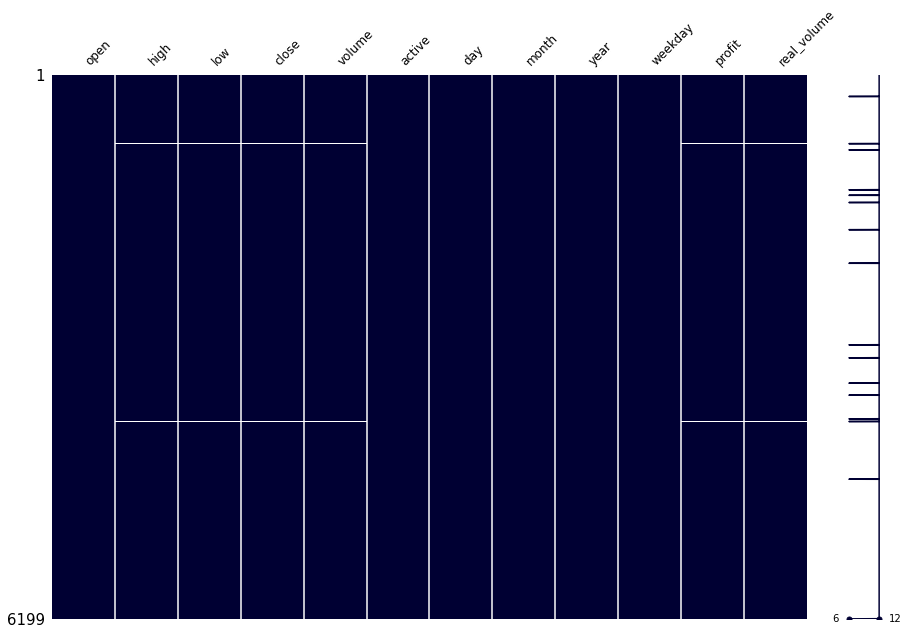

In [15]:
msno.matrix(df_filtered[df_filtered.active == 'DOGEUSDT'], figsize=(15, 10), fontsize=12, color=[0,0,0.2])

In [16]:
aux = df_all[df_all.active == 'DOGEUSDT']
close = aux[['close']]
q1,q3 = quantil(close)
lim1 = q1 - 1.5*(q3-q1)
lim2 = q3 + 1.5*(q3-q1)
outliers = len(aux[aux.close < lim1]) + len(aux[aux.close > lim2])
print('Para la cripto {} hay {} valores nulos de un total de {}, representa un {}% del total.'.format('DOGEUSDT', aux.isna().sum().sum(), len(aux), round((aux.isna().sum().sum()/len(aux))*100)))

Para la cripto DOGEUSDT hay 96 valores nulos de un total de 6199, representa un 2% del total.


# Parte II

En esta instancia trabajaremos con algunos features extras que iremos generando a partir de los precios disponibles. Para ello los invito a investigar talib, una de las librerías de python para análisis técnico.

Agreguen la serie de tasas de rendimientos de cada activo.
Calculen las medias móviles de los precios tomando n periodos hacia atrás (n a elección).
¿Conocen algunos indicadores técnicos? Entre los más conocidos podemos mencionar: RSI, MADC, ADX, etc... Pueden construirlos o calcularlos a partir de la librería.
Si por ejemplo, una característica tiene una varianza de un orden de magnitud mayor que la de las otras características, podría dominar la función objetivo y hacer que el estimador no pueda aprender de otras características correctamente como se esperaba. Para lograr esto se debe llevar a cabo un escalado o normalizado de datos. ¿Cuál es la diferencia?

Antes de calcular features, tenemos que imputar los valores faltantes ya que sino la librería no va a poder hacer los cálculos necesarios. Utilizaremos ffill para imputar los nulos, y en la misma iteración calcularemos los indicadores técnicos para usar posteriormente.

In [36]:
contador = 0
for i in set(df_all.active):
    aux = df_all[df_all.active == i]
    aux = aux.fillna(method='ffill')
    aux['EMA200'] = ta.EMA(aux['close'],200)
    aux['EMA100'] = ta.EMA(aux['close'],100)
    aux['EMA50'] = ta.EMA(aux['close'],50)
    aux['EMA20'] = ta.EMA(aux['close'],20)
    aux['RSI200'] = ta.RSI(aux['close'],200)
    aux['ADX200'] = ta.ADX(aux['high'], aux['low'], aux['close'],200)
    aux['MACD'] = ta.MACD(aux['close'], fastperiod=12, slowperiod=26, signalperiod=9)[0]
    if contador == 0:
        df_final = aux.copy()
        contador += 1
    else:
        df_final = pd.concat([df_final, aux])
        
df_final

,open,high,low,close,volume,active,day,month,year,weekday,profit,real_volume,EMA200,EMA100,EMA50,EMA20,RSI200,ADX200,MACD
unix,,,,,,,,,,,,,,,,,,,
2020-06-25 07:00:00,230.95,231.50,217.84,219.00,3.312726e+03,COMPUSDT,25,6,2020,Thursday,-5.174280,7.254869e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-25 11:00:00,218.99,231.48,202.97,229.80,3.688540e+03,COMPUSDT,25,6,2020,Thursday,4.936298,8.476266e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-25 15:00:00,229.80,239.00,203.00,212.80,1.400623e+04,COMPUSDT,25,6,2020,Thursday,-7.397737,2.980526e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-25 19:00:00,212.84,244.00,210.69,232.35,1.000744e+04,COMPUSDT,25,6,2020,Thursday,9.166510,2.325230e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-25 23:00:00,232.35,265.00,226.11,243.06,4.780416e+03,COMPUSDT,25,6,2020,Thursday,4.609425,1.161928e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04 23:00:00,16.11,16.45,16.10,16.37,7.820358e+05,DOTUSDT,4,5,2022,Wednesday,1.613904,1.280193e+07,17.784173,16.776270,15.918645,15.428453,47.335744,8.350106,0.011668
2022-05-05 03:00:00,16.36,16.37,16.16,16.16,6.636303e+05,DOTUSDT,5,5,2022,Thursday,-1.222494,1.072427e+07,17.768012,16.764067,15.928110,15.498124,47.126418,8.363539,0.064003
2022-05-05 07:00:00,16.16,16.23,15.78,16.01,8.133776e+05,DOTUSDT,5,5,2022,Thursday,-0.928218,1.302218e+07,17.750520,16.749135,15.931322,15.546874,46.977286,8.380750,0.092312


Recorro todo el dataframe y me quedo con el minimo de cada indice para ir armando una lista con la primer fecha que aparece en cada activo. Luego de esa lista, me quedo con el valor máximo, que va a coincidir con todos los activos y va a ser nuestro punto de partida para partir de ahi con todos los activos.

In [37]:
contador = 0
minimos = []
for i in set(df_final.active):
    aux = df_final[df_final.active == i]
    min_aux = aux.index.min()
    minimos.append(min_aux)

max_total = minimos[np.argmax(np.asarray(minimos))]
max_total

Timestamp('2020-11-04 15:00:00')

In [54]:
minimos.sort()

In [55]:
minimos

[Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-16 11:00:00'),
 Timestamp('2019-03-15 07:00:00'),
 Timestamp('2019-03-28 07:00:00'),
 Timestamp('2019-07-05 15:00:00'),
 Timestamp('2019-11-28 11:00:00'),
 Timestamp('2020-06-25 07:00:00'),
 Timestamp('2020-08-18 23:00:00'),
 Timestamp('2020-08-21 11:00:00'),
 Timestamp('2020-10-15 03:00:00'),
 Timestamp('2020-11-04 15:00:00')]

Recorro nuevamente el dataframe pero ahora hago un slice a partir de la fecha que obtuve en la celda anterior.

In [38]:
contador = 0

for i in set(df_final.active):
    aux = df_final[df_final.active == i]
    aux_1 = aux[max_total:]
    if contador == 0:
        df_final_max = aux_1.copy()
        contador += 1
    else:
        df_final_max = pd.concat([df_final_max, aux_1])    

df_final_max.shape

(62282, 19)

In [56]:
df_final.shape

(116390, 19)

Analizando la cantidad de datos con la que nos quedamos luego de hacer el slice, vemos que perdemos más de la mitad de los datos haciendo este recorte (de 116390 registros pasamos a 62282, por lo tanto es un 53%). Consideramos que la pérdida de datos es muy grande, por lo tanto vamos a dejar los datos como los tenemos. Posteriormente podemos agrupar los datos entre los activos que tienen los datos completos desde 2019 y luego los activos que varían entre fines de 2019 y principios de 2020.

Para armar el heatmap con la correlación entre las distintas criptomonedas, primero debemos crear un dataframe nuevo que tenga a cada activo como una columna distinta y usaremos como valor el precio de cierre de cada activo.

In [64]:
df_final = df_final.sort_values(by='active', ascending = True)

df_close_prices = pd.DataFrame(index=df_final[df_final.active == 'BTCUSDT'].index)

for i in set(df_final.active):
    df_close_prices[i] = df_final[df_final.active == i].close



Luego ordenamos las columnas alfabeticamente.

In [70]:
orden = ['AAVEUSDT',
 'ADAUSDT',
 'AXSUSDT',
 'BCHUSDT',
 'BNBUSDT',
 'BTCUSDT',
 'COMPUSDT',
 'DASHUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'EOSUSDT',
 'ETCUSDT',
 'ETHUSDT',
 'LINKUSDT',
 'LTCUSDT',
 'LUNAUSDT',
 'NEOUSDT',
 'XMRUSDT',
 'XRPUSDT']
df_close_prices = df_close_prices[orden]
df_close_prices

,AAVEUSDT,ADAUSDT,AXSUSDT,BCHUSDT,BNBUSDT,BTCUSDT,COMPUSDT,DASHUSDT,DOGEUSDT,DOTUSDT,EOSUSDT,ETCUSDT,ETHUSDT,LINKUSDT,LTCUSDT,LUNAUSDT,NEOUSDT,XMRUSDT,XRPUSDT
unix,,,,,,,,,,,,,,,,,,,
2019-03-16 07:00:00,NaN,0.05085,NaN,NaN,15.6400,4019.09,NaN,NaN,NaN,NaN,3.7984,4.5154,141.92,0.4812,61.01,NaN,9.532,54.08,0.31975
2019-01-01 07:00:00,NaN,0.04089,NaN,NaN,5.9439,3713.07,NaN,NaN,NaN,NaN,2.5697,5.0511,133.86,NaN,30.34,NaN,7.414,NaN,0.35181
2021-03-26 11:00:00,353.891,1.20679,4.41951,492.93,248.7096,53414.09,372.80,200.13,0.053129,31.8400,4.0574,11.6200,1644.18,26.3527,180.19,18.4065,41.010,224.21,0.54507
2021-03-26 07:00:00,346.550,1.20639,4.06606,478.25,247.1688,53378.06,373.38,194.82,0.052681,31.0543,3.8125,11.4700,1623.56,25.8418,176.55,18.7747,40.490,223.60,0.54603
2021-03-26 03:00:00,339.176,1.13055,4.02185,475.74,241.1793,52582.45,369.74,193.05,0.052489,30.4734,3.7263,11.3488,1617.17,25.5933,175.46,18.4092,40.231,222.06,0.53242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-11 23:00:00,NaN,0.06451,NaN,468.67,25.5605,10252.94,NaN,131.98,0.003080,NaN,5.2745,12.1898,243.91,3.9033,77.82,NaN,14.200,91.11,0.28471
2020-02-11 19:00:00,NaN,0.06272,NaN,462.12,25.5266,10204.00,NaN,130.16,0.003043,NaN,5.2621,11.9725,236.99,3.9109,76.70,NaN,13.827,88.54,0.28013
2020-02-11 15:00:00,NaN,0.06180,NaN,462.78,25.2443,10206.22,NaN,130.29,0.003017,NaN,5.2553,11.9829,236.48,3.8157,76.53,NaN,13.904,88.24,0.28008


In [ ]:
Y por ultimo ejecutamos el código para generar la matriz de correlación entre las el precio de cierre y las distintas criptomonedas.

<AxesSubplot:>

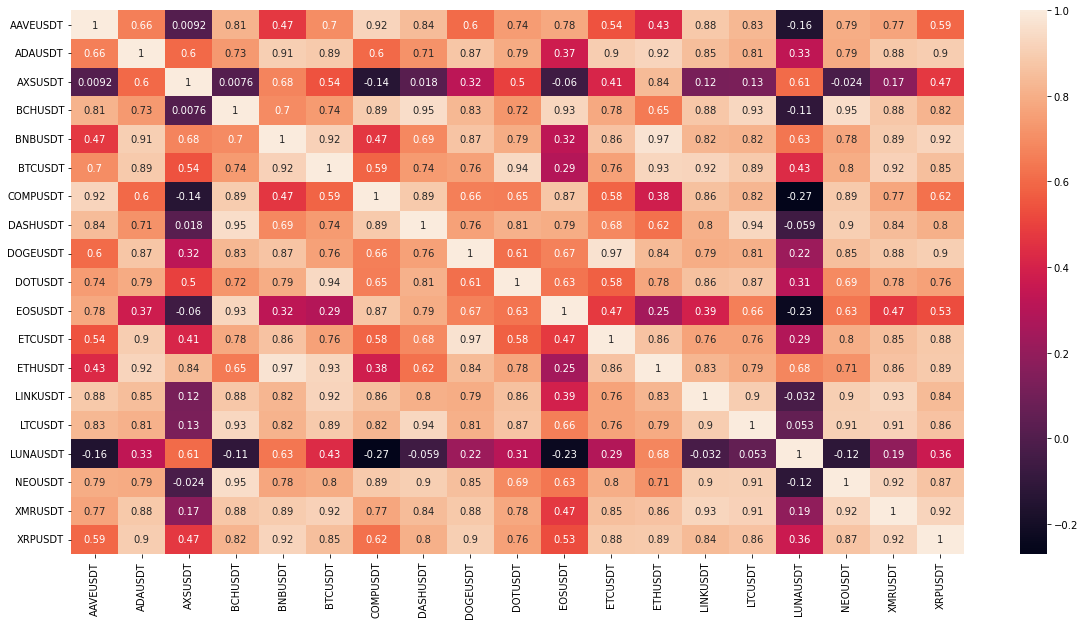

In [71]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_close_prices.corr(method='pearson'), annot = True)